In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Working through selected parts of the code from the Andrej Karpathy "The spelled-out intro to neural networks and backpropagation: building micrograd" lecture at https://www.youtube.com/watch?v=VMj-3S1tku0. (I'm not taking notes for everything/most things - just occasionally.)

Remember the fundamental that differentiating/taking the derivative or gradient of the end function (like a loss function) w/ respect to something that goes into producing the value of that end function (like a component - call it 'a', or 'b', or 'c') means conceptually answering the question 'how does the end function change when i tweak a, or b, or c by a very small amount. If the answer to this question is positive, then it means that increasing the vallue of the component by a little increases the value of the end function, and if it's negative then it means that increasing the value of the component decreases the value of the end function. (Later, when we're adjusting weights, since we want to minimize loss functions, we negate the value of the gradient in order to change the weight in the correct direction to make the value of the loss function smaller.)

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0 # what's the deriv of the loss function w/ respect to this value, start at 0 - i.e. no effect
        self._backward = lambda: None # what func propogates the gradient?
        # track the components that went into creating this value and by what math op, for use in autodiff
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data}, label="{self.label}")'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # for addition, just pass through what the parent has (via the chain rule); += to accumulate from mult parents (if/when we have that)
            other.grad += 1.0 * out.grad            
        out._backward = _backward
        
        return out

    def __radd__(self, other): # handle other + self by redirecting to __add__
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # for multiplicaton, multiply other/self data by parent (again, chain rule)
            other.grad += self.data * out.grad            
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # handle other * self by redirecting to the __mul__ impl above (standard Python) 
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supports int and float powers, at least for now'
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # i.e., power derivative rule then * chain rule
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1 # a/b is the same as a*(b^-1), as we implemented pow just above

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # it's the 'local deriv' * prev grad (chain rule), and local deriv of e^x is e^x (which is in out since we just calculated e^x there)
        out._backward = _backward

        return out

    def backward(self):
        # then build a list of Values that are in order from starting/no children to the output (which we'll then reverse when calling _backward)
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0 # end/starting node has a grad of 1 (dL/dL) since adjusting that 'by a little' changes the output of the same val by the same 'a little'       
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = (a * b) + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, label="L")

In [3]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0, label="")

In [4]:
# quickie code to visualize graphs of operations - details not relevant for autograd, see lecture for a bit
from graphviz import Digraph

def trace(root_value):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root_value)
    return nodes, edges

def draw_dot(root_value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR is left to right

    nodes, edges = trace(root_value)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

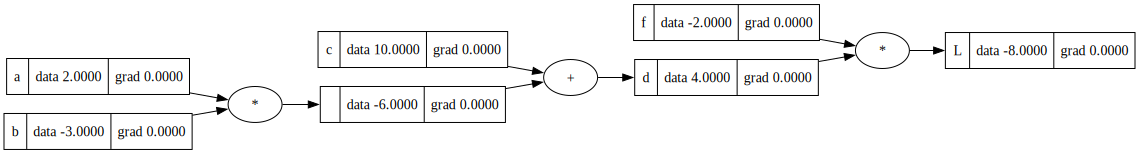

In [5]:
draw_dot(L)

Above, calculating L (i.e., the stand-in for the loss function) is the forward pass. We want to know the derivative of L with respect to each node that leads to L - i.e., how does L change when we tweak f, or d, etc.

We manually calculated the gradients as part of the lecture from around 30m to 60m or so - key thing is the use of what he called the 'local gradient' at the particular node and the gradient of the parent node, multiplying the two together because of the chain rule.

In [6]:
# we can numerically verify grad calc by tweaking the 'with respect to' value and manually calculating the gradient,
# which is the value of the 'gradient of' with a tiny bit added to it minus the value w/o it, normalized by the 
# tiny value - i.e., where h is the tiny bit:
# dL / da = (L2 - L1) / h

def quickie_validation():
    # he put this in a func so it wouldn't change the notebook/global vars

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

quickie_validation()

-3.9999999999995595


Create a simple network w/ weights and input values - still not exactly like a real NN, since we don't have many weights in vectors/matrices, etc. - but a bit more like that than the above. The Value constructor sets the gradient for each Value to zero as part of this creation.

In [7]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # set so the grad numbers come out nicely
# x1w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

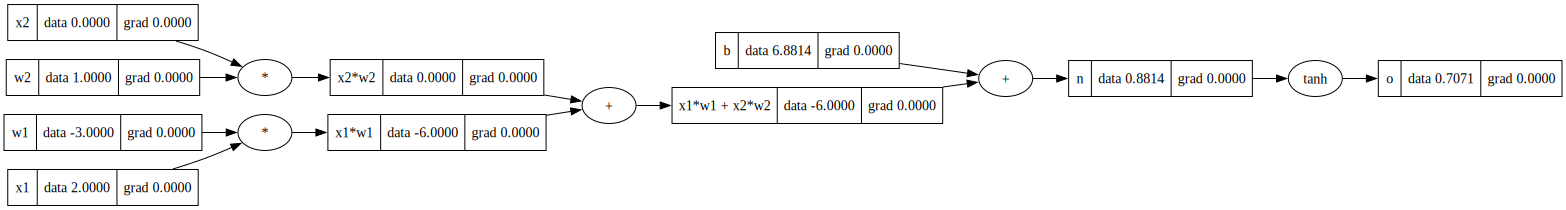

In [8]:
draw_dot(o)

Argh... I had a cell w/ notes showing how to manually backpropogate, and also how to call _backward starting from the end, and then I deleted it accidentally and got lost in the Jupyter undo/redo stack, and now it's gone. I'm not going to worry about it and just go on to the topological sort impl that figures out in what order to call _backward.

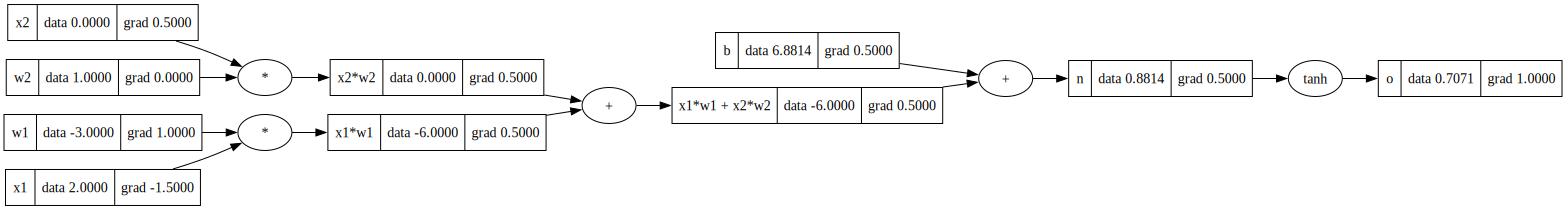

In [9]:
o.backward()
draw_dot(o)

Next few show how we correctly calc the gradients when we have multiple parents, because we accumulate (+=) each grad - 'deposit the gradients from each branch' - rather than the original and not correct overwrite.

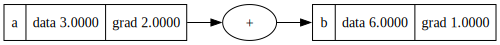

In [10]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

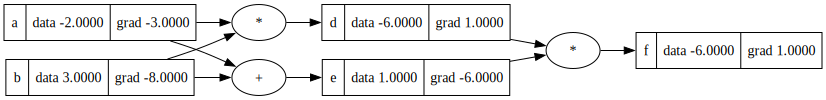

In [11]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

Originally we directly coded the derivative of tanh in the tanh _backward. Another way to represent the derivative is as an expression using exp, and now that we have implemented the components that we need to do this expression in Value (i.e., exp, subtraction, division) we can replace the use of tanh with the expression, and we should get the same gradients as we do above. 

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # set so the grad numbers come out nicely
# x1w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

And, yep, the forward pass/value at the end are identical, and the gradients at the beginning are also identical, as shown below. (Scroll to the right to compare and see the many more nodes.)

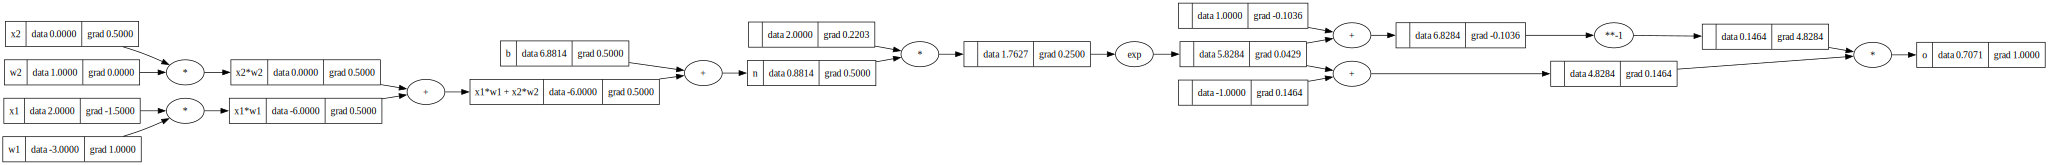

In [13]:
draw_dot(o)

Now, show how we'd do the same thing as above but using PyTorch, and get the same forward pass result at the end and the same gradients at the start... yep - the numbers below and above match. (Of course, in the real world we wouldn't have single-valued tensors, etc.)

In [14]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True # normally we'd not do grads for things like input data
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
--
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [16]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

Now, I'll implement a multi-layer perceptron.

In [17]:
import random

In [18]:
class Neuron:

    def __init__(self, nin): # nin is the number of inputs to the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # forward pass: w * x + b, callable like so where n is a Neuron with dim 2: n([2.0, 3.0]
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b] # single list with all the weights and the bias

class Layer:

    def __init__(self, nin, nout): # nin is the # of inputs to each neuron in the layer; nout is the # of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # do weighted sum for each neuron in the layer 
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
         

class MLP:

    def __init__(self, nin, nouts): 
        # nin in is the # of inputs to the MLP/same as the # of inputs to each neuron in the first layer
        # nouts is a list of ints where each int is the # of neurons in a layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
x = [2.0, 3.0, -1.0]
#n = Layer(3, 3) # three neurons, each w/ three inputs
n = MLP(3, [4, 4, 1]) # three input vals, to an MLP with two layers w/ four neurons each and then an output layer with one neuron
n(x)

Value(data=0.39323273429112565, label="")

In [20]:
len(n.parameters())

41

And our draw_dot function works w/ this single output value - n(x) returns the forward pass Value, showing a graph with a ton of calcs. Fundamentally, we can call backward on this final node and get the gradients for all the items in the entire graph. 

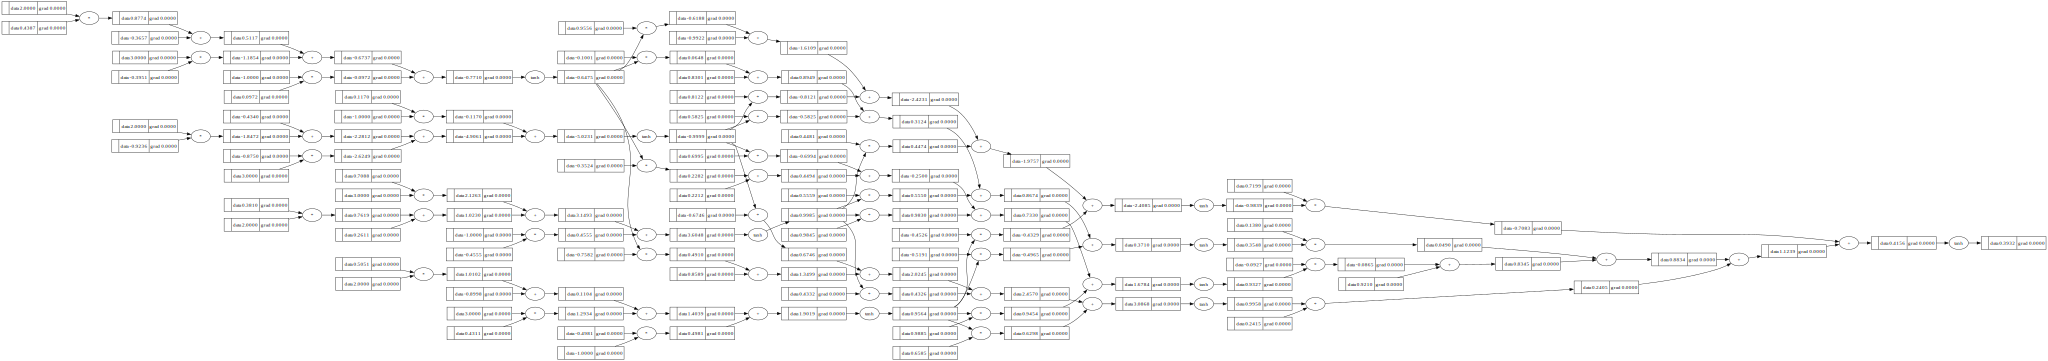

In [21]:
draw_dot(n(x))

In [22]:
# four inputs each with three vals, and four target outpus - i.e. a simple binary classifier
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [23]:
# current outputs - compare to the prev desired targets 
ypred = [n(x) for x in xs]
ypred

[Value(data=0.39323273429112565, label=""),
 Value(data=0.6382604167154833, label=""),
 Value(data=0.5463013642498249, label=""),
 Value(data=0.4338990536936882, label="")]

In [24]:
# mean squared error
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.763581898202384, label="")

In [25]:
# calculate _all_ of the gradients using what we know for each/all four of the inputs
loss.backward()

And the loss var is a Value too, which is tied back to four forward passes because it comes from the MSE calc that includes these four forward pass values. This means the graph is even bigger than it was above, but we can draw it and it works. And we have gradients for each of the Value nodes (including those where it's not useful, like on the inputs, in contrast to on the weights and the biases).

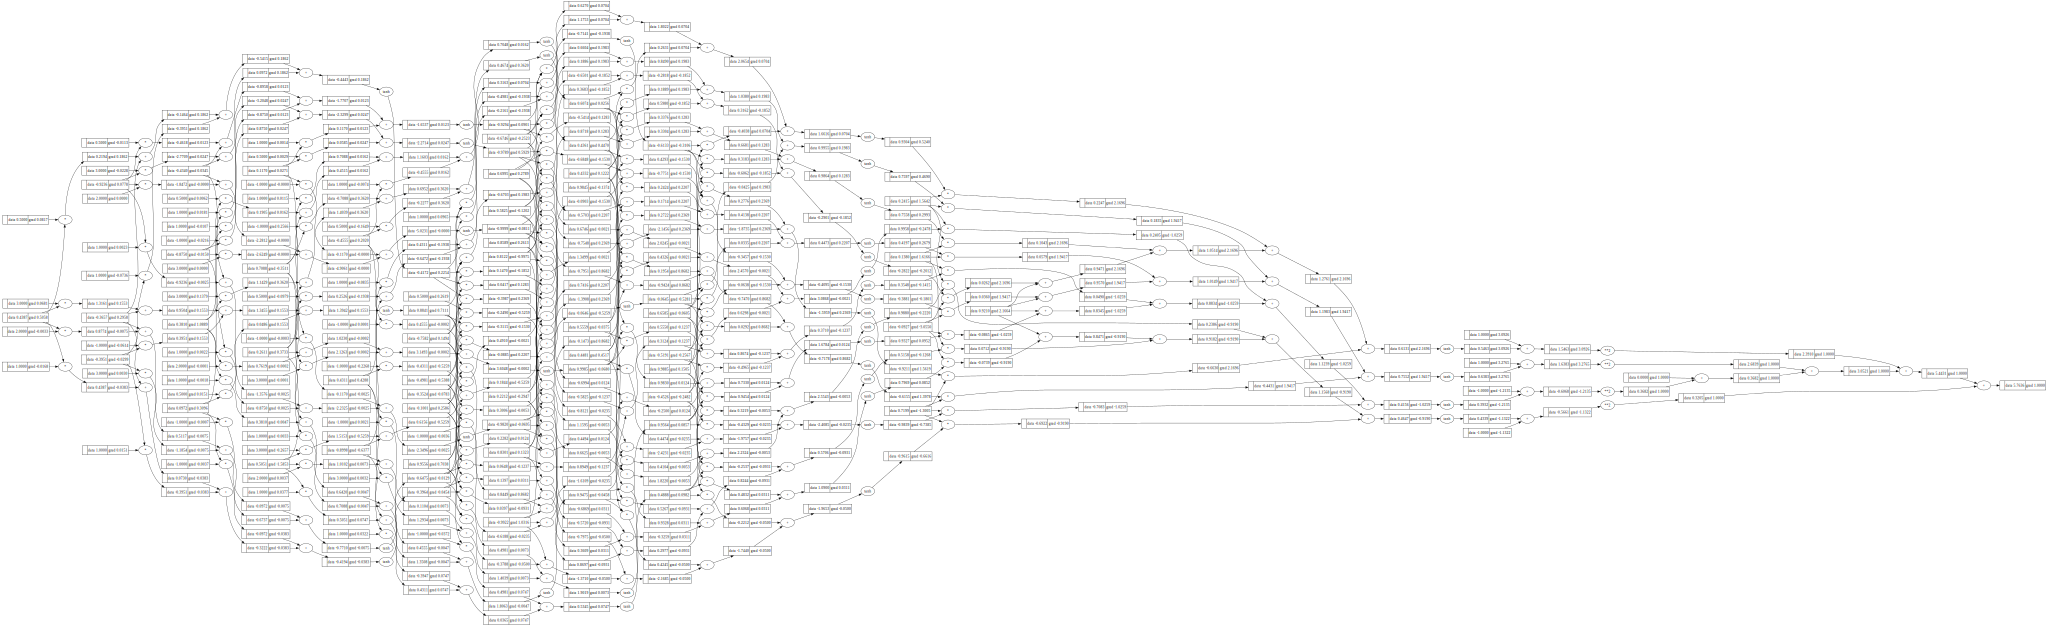

In [26]:
draw_dot(loss)

In [27]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

0.43870147206682164
0.5057970423216025


And now we can use the gradients we populated for each value (again, really only the gradients we populated for the values that are parameters - the weights and biases - matter) to modify the value of the weights and biases slightly so as to make the loss slightly lower. The gradient shows what to do to make the loss function higher, so we add a negation at the front because we want to make the loss lower.

In [28]:
for p in n.parameters():
    p.data += -0.01 * p.grad # 0.01 is the step size - we only want to update a bit

In [29]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

0.4336435016436056
0.5057970423216025


And now we see that the weight in the example above is slightly higher (at least in the run where I'm writing this code, since it's random) - since the gradient for this weight was negative. (I.e., when the gradient is negative, making the weight/bias/data bigger makes the resulting loss function lower.) 

In [30]:
ypredafter = [n(x) for x in xs]
lossafter = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypredafter))
loss, lossafter

(Value(data=5.763581898202384, label=""),
 Value(data=5.464479087669539, label=""))

And, the above shows that the loss after the upate is lower than before - we're improving.

And now that we have the pieces, I'll clean things up here starting from the data and a newly initialized neural net. This is gradient descent. (Not stochastic gradient descent I think because we're not picking a subset of the data at random - we just use the full set of four inputs/outputs each time.) 

In [31]:
n = MLP(3, [4, 4, 1]) # three input vals, to an MLP with two layers w/ four neurons each and then an output layer with one neuron
n(x)

Value(data=-0.8604802866627211, label="")

In [32]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [33]:
for k in range(40):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass to set gradients
    # don't forget to zero out the gradients/reset them to zero (needed since the grad updates are always +=)
    # the above is a common bug (see Karpathy's tweets for common issues where I think he said this was #3) 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights and biases using the gradients
    for p in n.parameters():
        p.data += -0.05 * p.grad 

    print(k, loss.data)

0 7.643146370895064
1 6.340047341471392
2 3.690047694158058
3 2.8821185864767846
4 2.5292059109279217
5 2.2191011955414197
6 1.8432047238975384
7 1.443410375430277
8 1.0896572888274336
9 0.820480099032275
10 0.6304792883619161
11 0.4982108175140419
12 0.4046972923936807
13 0.3368665208576702
14 0.28629036124265855
15 0.24758103749634788
16 0.21724811420173168
17 0.19298044893326993
18 0.1732098685736567
19 0.15684607791162067
20 0.14311333837964113
21 0.13144782467097577
22 0.12143168377401595
23 0.11274972563614621
24 0.10516036467768383
25 0.09847572630989879
26 0.09254776951069124
27 0.08725843598037121
28 0.08251254400994049
29 0.07823258548643797
30 0.07435486364034873
31 0.07082658939458271
32 0.06760367257319067
33 0.06464902326859222
34 0.06193123224352073
35 0.05942353608573425
36 0.05710299851080719
37 0.05494985733202658
38 0.052946999561482064
39 0.05107953645641155


In [34]:
ypred

[Value(data=0.9083193147908677, label=""),
 Value(data=-0.846120582417085, label=""),
 Value(data=-0.9414547263844943, label=""),
 Value(data=0.87522915325436, label="")]

And it works! The predicted values are close to the 1, -1, -1, 1 that we have as our ground truth.